https://www.kaggle.com/code/ahmedashrafhelmi/ecg-classification-rnn-gru-lstm

In [1]:
import torch
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

PyTorch version: 2.5.1+cpu
CUDA available: False
No CUDA devices found.


In [2]:
import pandas as pd
import numpy as np
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
dataframes = {}
# directory_path = 'Arrhythmia_Dataset'
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path)


In [3]:
print(dataframes.keys())

dict_keys(['mitbih_test', 'mitbih_train', 'ptbdb_abnormal', 'ptbdb_normal'])


## Exploratory Data Analysis

In [4]:
# df = dataframes['MIT-BIH Arrhythmia Database']

# Retrieve train and test datasets
train_df = dataframes['mitbih_train']
test_df = dataframes['mitbih_test']

In [5]:
# Preview of train dataset
train_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Check number of samples in datasets
print(f"Number of samples in train data: {train_df.shape[0]}, test data: {test_df.shape[0]}\n")

# Check distribution of classes in test and train sets
print("Train dataset class distribution")
print(train_df.iloc[:, -1].value_counts())
print("\nTest dataset class distribution")
print(test_df.iloc[:, -1].value_counts())

Number of samples in train data: 87553, test data: 21891

Train dataset class distribution
0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Test dataset class distribution
0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [7]:
# Labels for numbered categories
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

In [8]:
# Missing/Duplicate values

C:\Users\limqi\AppData\Local\Temp\ipykernel_5696\3740686426.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


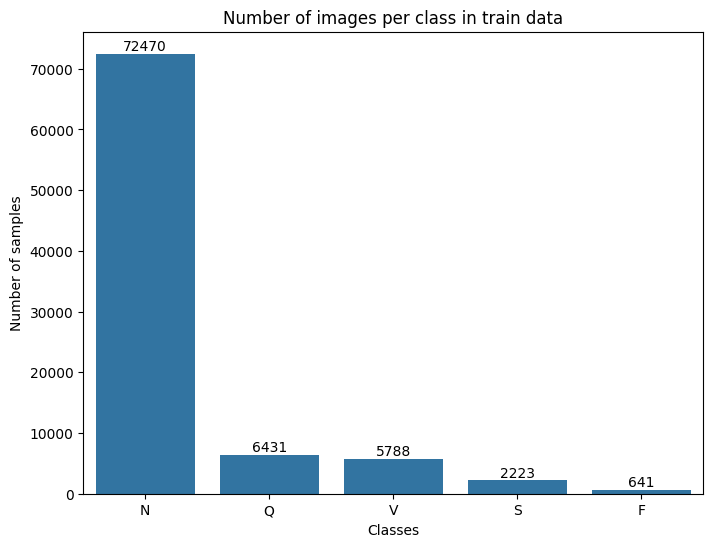

In [9]:
import seaborn as sb
import matplotlib.pyplot as plt

train_counts = train_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

C:\Users\limqi\AppData\Local\Temp\ipykernel_5696\578734644.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


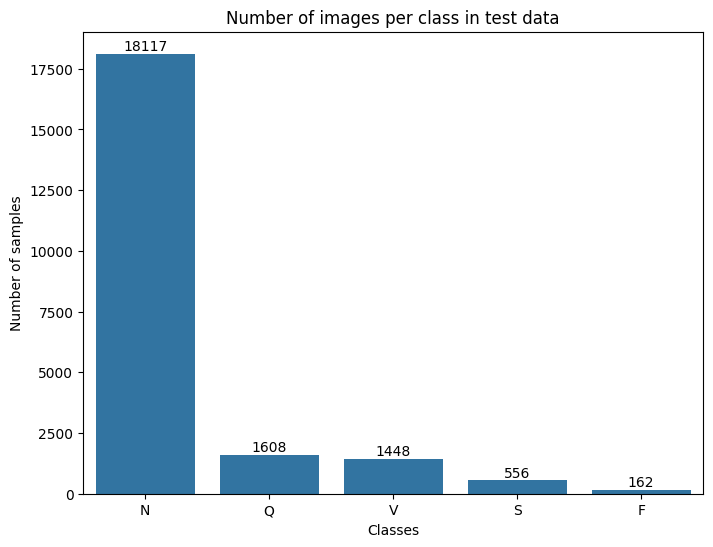

In [10]:
test_counts = test_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

## Preprocess dataset

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Separate features and labels
X_train = train_df.iloc[:, :-1].values  # Exclude label
y_train = train_df.iloc[:, -1].values   # Labels

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Scaling the dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the training data to obtain new train and validation sets
# Stratifying the split so both train and validation sets have same class distribution
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"New Training set: {X_train_new.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

New Training set: (70042, 187)
Validation set: (17511, 187)
Test set: (21891, 187)


In [34]:
# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features), one feature per timestep
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test.shape[0], X_test.shape[1], 1))


print(f"New Training set size: {X_train_new.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_scaled.shape}")

New Training set size: (70042, 187, 1)
Validation set size: (17511, 187, 1)
Test set size: (21891, 187, 1)


## RNN Model

In [12]:
class RNNModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size = inputSize,
            hidden_size = hiddenSize,
            num_layers = 1,
            batch_first = True,
            dropout = 0.2
        )

        self.fc = nn.Linear(hiddenSize, numClasses)
        return

    def forward(self, x):
        # Forward pass through RNN layers
        out, _ = self.rnn(x)

        # Use output from last timestep
        out = out[:, -1, :]

        # Pass output to fully connected layer
        out = self.fc(out)

        return out

In [35]:
# Variables
inputSize = 1
hiddenSize = 64
numClasses = 5
learningRate = 0.001
numEpochs = 10

# Instantiate model
rnn_model = RNNModel(inputSize, hiddenSize, numClasses)
optimizer = optim.Adam(rnn_model.parameters(), lr=learningRate)

# Loss function
criterion = nn.CrossEntropyLoss()

c:\Users\limqi\Desktop\Neural-Networks-Project\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [36]:
# Prepare datasets in batches
from torch.utils.data import DataLoader, TensorDataset

# Define batch size
batch_size = 32

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(torch.as_tensor(X_train, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.as_tensor(X_val, dtype=torch.float), torch.as_tensor(y_val, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [37]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = rnn_model.to(device)

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(numEpochs):
    rnn_model.train()  # Set the model to training mode
    train_loss = 0
    train_correct = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
        
        # Forward pass
        outputs = rnn_model(X_batch)
        # print(f'Output {outputs.shape}, y_batch {y_batch.shape}')
        loss = criterion(outputs, y_batch.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        
        train_loss += loss.item() * X_batch.size(0)  # Accumulate loss
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    rnn_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    
    with torch.no_grad():  # No need to calculate gradients for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
            outputs = rnn_model(X_batch)
            loss = criterion(outputs, y_batch.long())
            val_loss += loss.item() * X_batch.size(0)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch results
    print(f'Epoch [{epoch + 1}/{numEpochs}], '
        f'Train Loss: {train_loss:.4f}, '
        f'Train Accuracy: {train_accuracy:.4f}, '
        f'Val Loss: {val_loss:.4f}, '
        f'Val Accuracy: {val_accuracy * 100:.2f}%')

Output torch.Size([32, 5]), y_batch torch.Size([32])


NameError: name 'correct' is not defined

In [ ]:
PATH = "./model/rnn_model.pth"
# Save trained model
torch.save(rnn_model.state_dict(), PATH)

In [ ]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='TValidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend(loc='lower right')
plt.show()